# Introductory Notebook 3: Advanced Selection Options for Counterfactuals

This notebook will discuss methods for selecting counterfactuals according to different priorities. 

In [1]:
import sys
sys.path.append('../src/')
import decode_mcd
from decode_mcd import mcd_problem
from decode_mcd import mcd_dataset


from decode_mcd import design_targets
from decode_mcd import mcd_generator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In the notebook we will cover mixed datatypes and generating counterfactuals with multiple mixed objectives types. 

### Creating a Dataset

First we build the validity function used in the example. It consists of four "arcs" and one circle. 

In [2]:
def validity(x): #Validity function for the 2D case
    x = np.array(x)
    x1 = x[:,0] #Separate the two dimensions for clarity
    x2 = x[:,1]
    fc = np.less(np.sqrt(np.power((x1-0.3), 2) + np.power((x2-0.3), 2)), 0.1) #Circle
    sc = np.less(np.power(np.power(np.power((x1-x2), 6)-1, 2) + np.power(np.power((x1+x2), 6)-1, 2), 2), 0.99) #Arcs
    union = np.logical_or(fc, sc) #If points are in circle or arcs they are valid
    y = union.reshape(-1,1) #reshaping here is important. We need to return a 2D array. 
    return y

Let's take a look at the validity function to confirm:

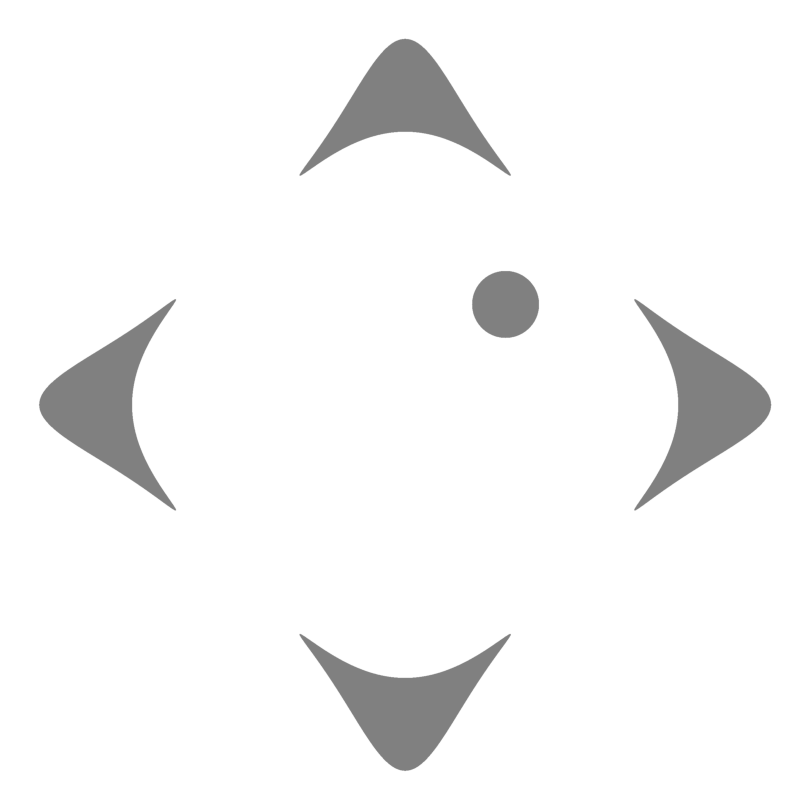

In [3]:
def plot_validity(validity, rangearr):
    xx, yy = np.mgrid[rangearr[0,0]:rangearr[0,1]:.001, rangearr[1,0]:rangearr[1,1]:.001]
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = validity(grid)
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
    img = ax.imshow(1-Z.T, cmap="gray", alpha=0.5, origin='lower', extent = rangearr.flatten())
    ax.axis('off')
    return ax

ranges = np.array([[-1.15, 1.15], [-1.15, 1.15]])

ax = plot_validity(validity, ranges)
plt.show()

Great! Now we sample some data from a uniform distribution to serve as our starting data. 

8.44% of the points are valid.


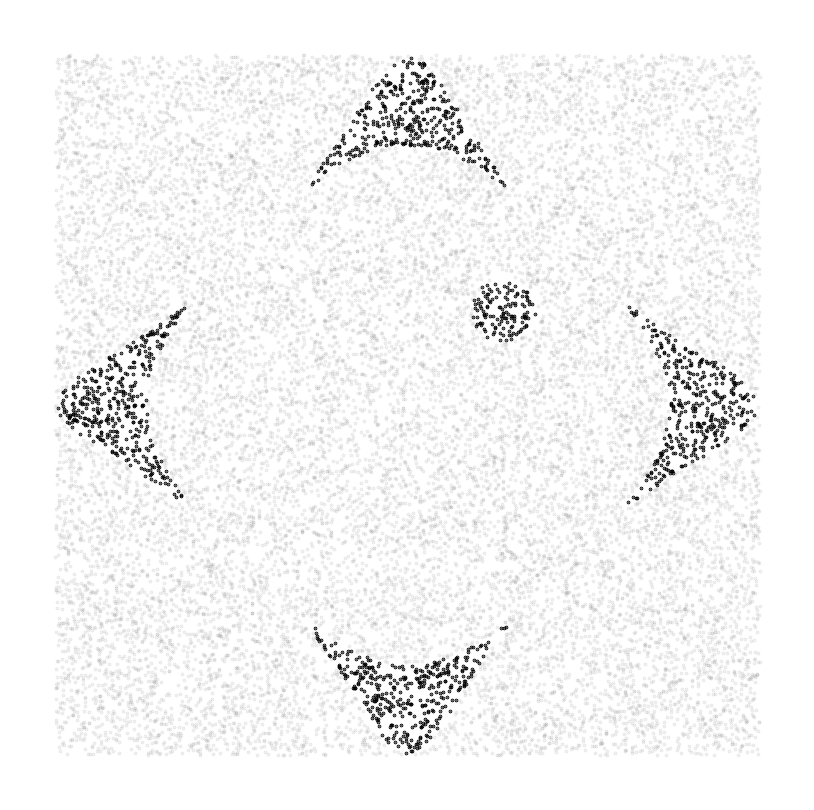

In [4]:
x = np.random.rand(20000, 2) #Sample 10000 2D points
x = x*2.2-1.1 #Scale from -1.1 to 1.1

#Calculate the y values
y = validity(x)

#Separate the valid and invalid points (we flatten because y is 2D)
valid = x[y.flatten()]
invalid = x[~y.flatten()]
print(f"{100*len(valid)/len(x):.2f}% of the points are valid.")

plt.figure(figsize=(5,5), dpi=200)
plt.scatter(valid[:,0], valid[:,1], color="black", label="Valid", s=0.1)
plt.scatter(invalid[:,0], invalid[:,1], color="gray", label="Invalid", s=0.1, alpha=0.2)
plt.axis("off")
plt.show()

We'll set up our query to be a point in the center at 0,0. 

In [5]:
x_query = np.zeros((1,2))

### Setting up MCD

Now we are ready to set up the `McdDataset`. As you might expect, we just have two continuous (real) variables each ranging from -1.1 to 1.1. 

In [6]:
from pymoo.core.variable import Real, Integer, Choice, Binary 
datatypes=[Real(bounds=(-1.1, 1.1)), 
           Real(bounds=(-1.1, 1.1))]

data = mcd_dataset.McdDataset(x=x, y=y, x_datatypes=datatypes)

Next, we create the design targets and the `McdProblem`. We want set a hard lower bound of 10 for O1 with no upper bound, meaning C(D(A), B)>=10. We also set a requirement that O2 must be true, meaning that D(C(B, A))>=0

In [7]:
#We set up a CategoricalTarget for our only objective (index 0) specifying only True as the desired class. 
#Desired_classes is a list. In problems with multiple classes, this list specifies the acceptable classes.
target_1 = design_targets.CategoricalTarget(label = 0, desired_classes=[True])

#We then create a DesignTargets object with the two targets.
y_targets = design_targets.DesignTargets(categorical_targets=[target_1])

In [8]:
problem = mcd_problem.McdProblem(mcd_dataset=data, x_query = x_query, y_targets = y_targets, prediction_function=validity)

Finally, we create the `McdGenerator`.

In [9]:
generator = mcd_generator.McdGenerator(mcd_problem=problem, pop_size=100, initialize_from_dataset=True)

### Generating Counterfactuals with Different Sampling Weights
We are now reaching the main learning objective of this notebook: Sampling counterfactuals with different priority weights. First we generate counterfactuals.

In [10]:
generator.generate(n_generations=100)

20000 dataset entries found matching problem parameters
Initial population initialized from dataset of 20000 samples!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |     12 |  0.000000E+00 |  0.9156542173 |             - |             -
     2 |      100 |     14 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      200 |     16 |  0.000000E+00 |  0.000000E+00 |  0.2862455603 |         nadir
     4 |      300 |     16 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      400 |     15 |  0.000000E+00 |  0.000000E+00 |  0.9512552490 |         nadir
     6 |      500 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0066002542 |             f
     7 |      600 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0005030899 |             f
     8 |      700 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0036856820 |             f
     9 |      800 |     

Next, we sample from the generated counterfactuals using the default settings and plot what we get. 

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


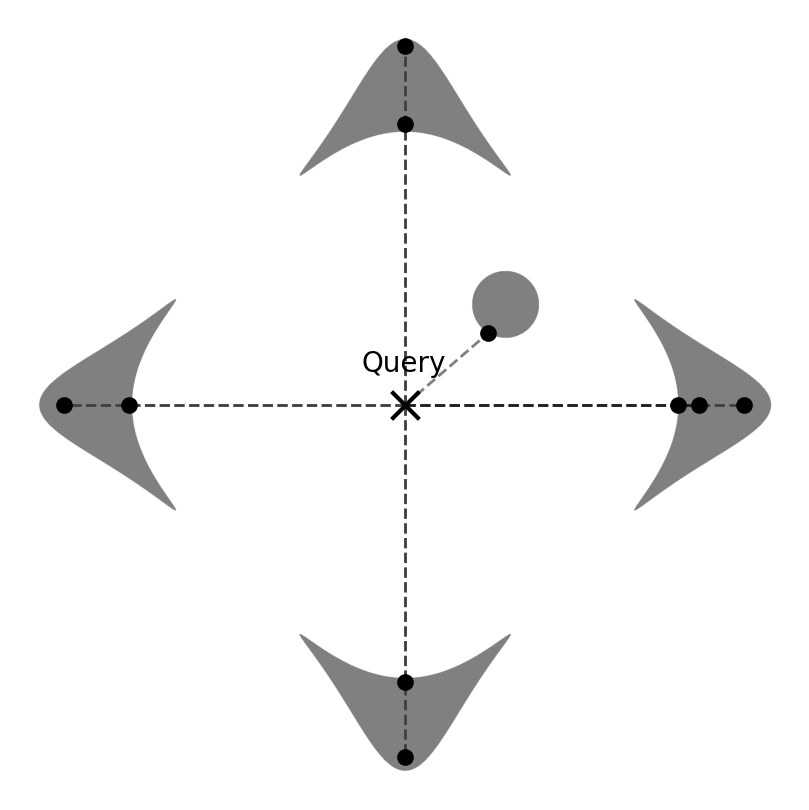

In [11]:
def plotcfs(validity, counterfactuals, x_query, rangearr, links=True):
    counterfactuals = np.array(counterfactuals)
    query = x_query[0]
    ax = plot_validity(validity, rangearr)
    ax.scatter(query[0], query[1], s=100, c="k", alpha = 1, marker="x")
    ax.annotate("Query", (query[0]-.13, query[0]+0.1))
    if links: 
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=100, c="k", alpha = 1, marker=".")
        for i in range(np.shape(counterfactuals)[0]):
            ax.plot([query[0], counterfactuals[i,0]], [query[1], counterfactuals[i,1]],c = "k", linestyle="--", lw=1, alpha=0.5)
    else:
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=1, c="k", alpha = 1, marker=".")

default_cfs = generator.sample(num_samples=10)

plotcfs(validity, default_cfs, x_query, ranges) #plot sampled counterfactuals

This is a nice set of counterfactuals, but can we sample a better set? During generation, MCD identifies a lot of potential candidate counterfactuals. Let's take a look at all the possible counterfactuals that MCD identifies.

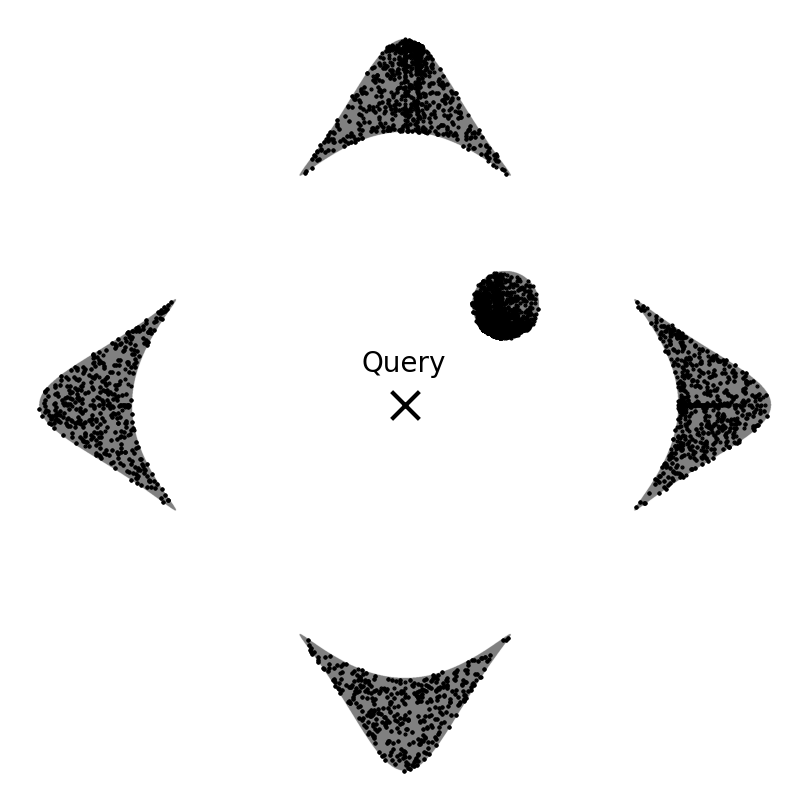

In [12]:
plotcfs(validity, generator._all_cf_x, x_query, ranges, links=False) #plot all counterfactuals

What if we want counterfactuals with different priorities? What if we value proximity to the query above all else? What if we care mainly about the diversity of the generated counterfactuals? As discussed in the paper, MCD breaks counterfactual quality into several attributes and use a weighting of these when selecting counterfactuals. These are: proximity, manifold proximity, and sparsity. Finally, there is a separately specified diversity weight that affects the diverse sampling and is applied after the other attributes are aggregated. For reference, the default values are shown below. We can see these are identify to the case where we did not specify any weights in the `generator.sample()` argument. We have found that these weights work fairly well in a lot of problems, but the selection of these parameters is highly dependent on your problem (and very dependent on scaling, dimensionality, etc.)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


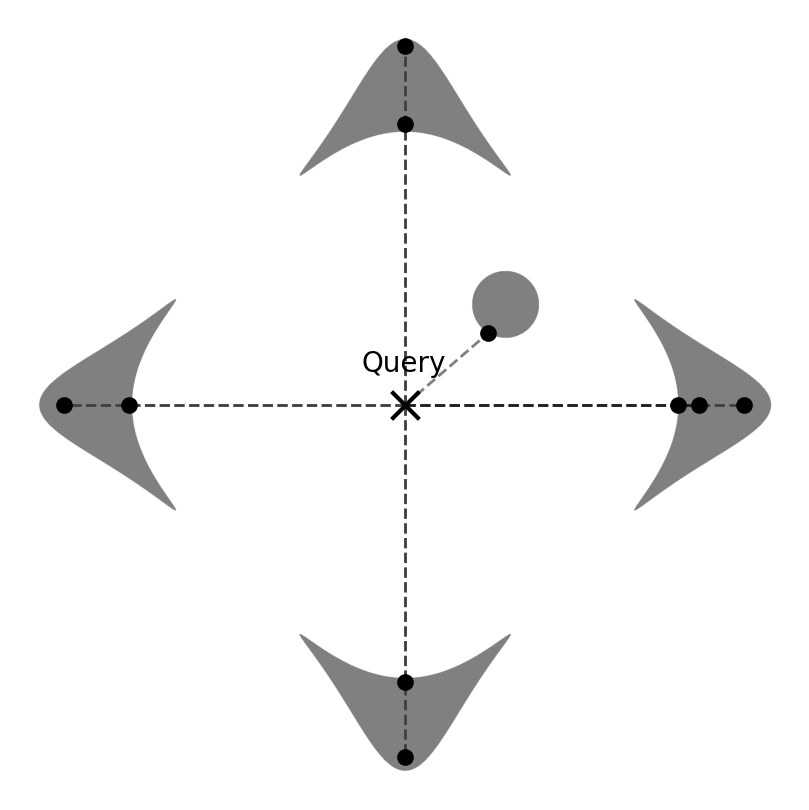

In [13]:
default_cfs = generator.sample(num_samples=10, proximity_weight=1, manifold_proximity_weight=0.5, sparsity_weight=0.3, diversity_weight=0.3)

plotcfs(validity, default_cfs, x_query, ranges)

For contrast, let's see what happens when we increase proximity weight by 10x. We can see that most counterfactuals are sampled from the most proximal mode, the circle.

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


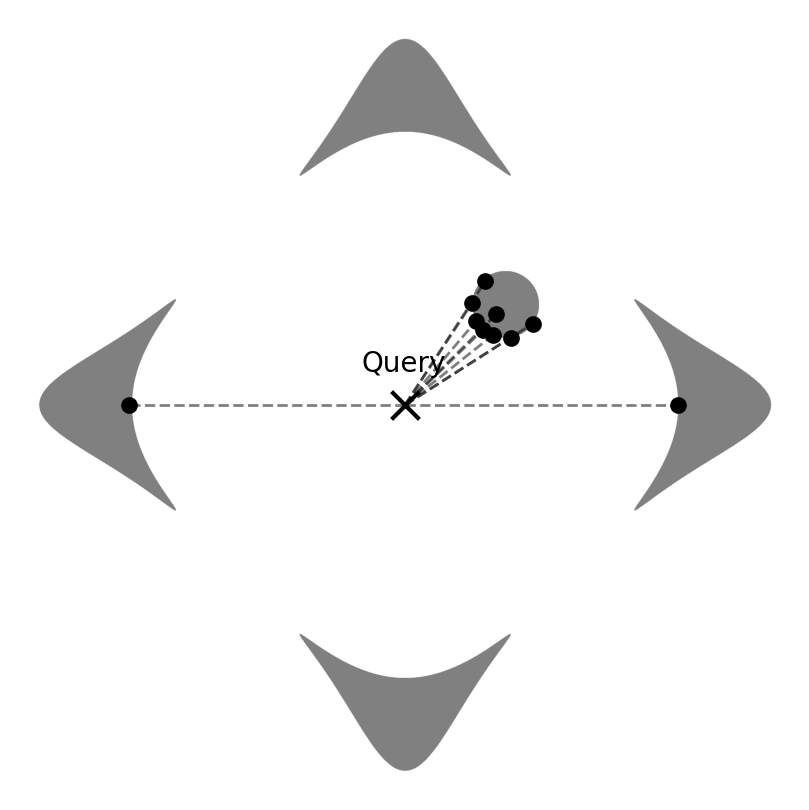

In [14]:
proximal_cfs = generator.sample(num_samples=10, proximity_weight=10)

plotcfs(validity, proximal_cfs, x_query, ranges)

Next, let's see what happens when we increase sparsity weight by 10x. We can see all counterfactuals are sampled to only change one of the two parameters of the query.

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


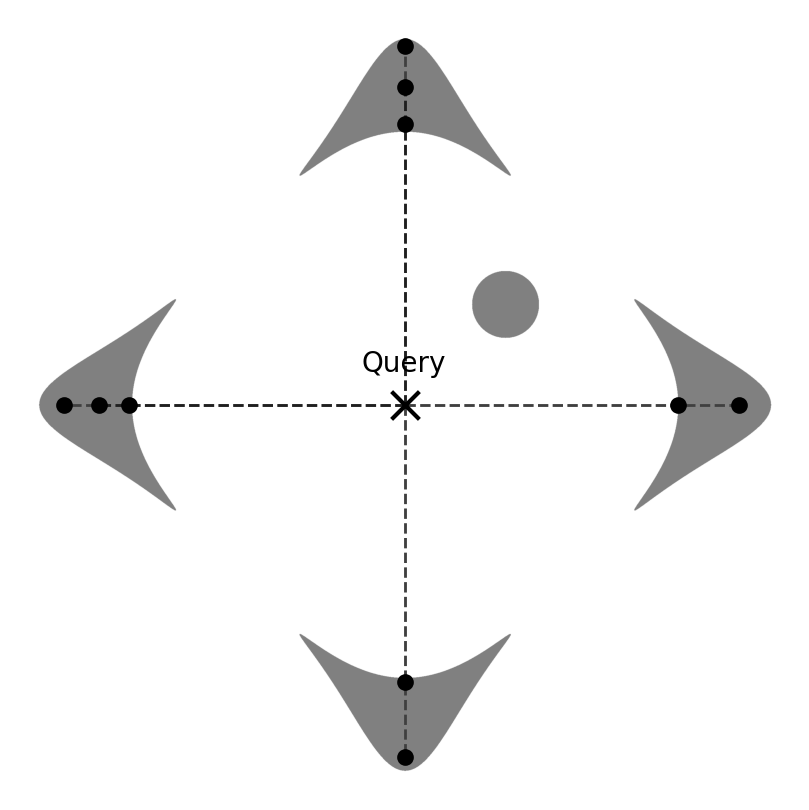

In [15]:
sparse_cfs = generator.sample(num_samples=10, sparsity_weight=3)

plotcfs(validity, sparse_cfs, x_query, ranges)

We will skip manifold proximity because we samples from a uniform distribution and it isn't very interesting in this case. However, we will try cranking up the diversity weight. In this case, MCD prioritizes spacing the counterfactuals far apart to maximize diversity of the counterfactual set. 

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


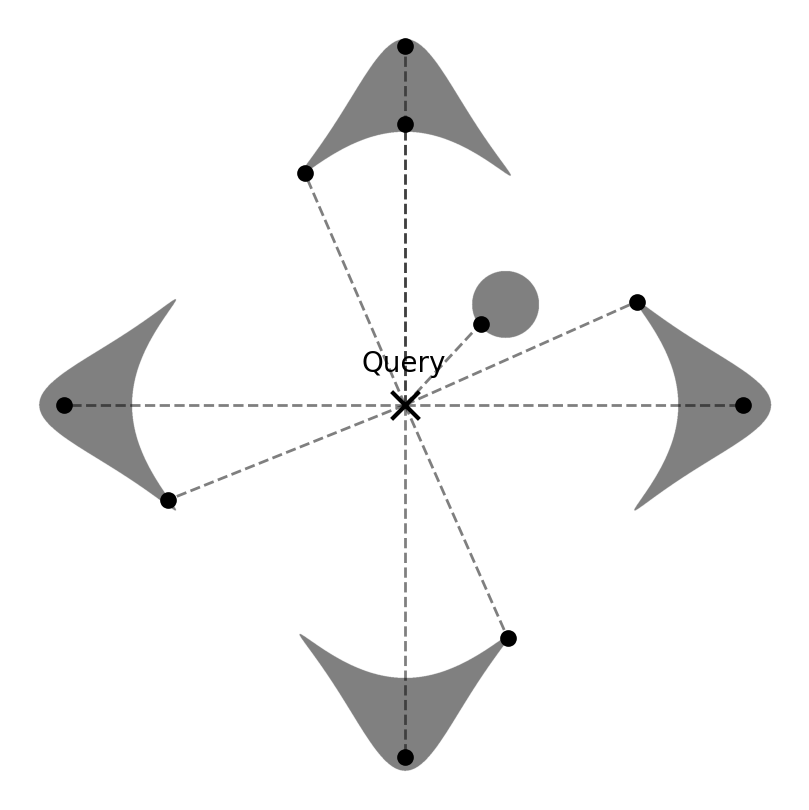

In [16]:
diverse_cfs = generator.sample(num_samples=10, diversity_weight=3)

plotcfs(validity, diverse_cfs, x_query, ranges)

### Sampling with Optimization Objectives
Now lets modify the problem to add an objective in addition to a constraint. Let's say we want to prioritize points that lie closer to the top right corner. We will two a simple objective which are just -x1 and -x2 and minimize these, essentially prioritizing counterfactuals that lie closer to the top right corner. (MCD minimizes by default, so we construct our objectives as such). First, we set up the evaluation function and the new y data, then reinitialize the `McdDataset`.

In [17]:
def objective1(x):
    x = np.array(x)
    y = -x[:,0:1]
    return y

def objective2(x):
    x = np.array(x)
    y = -x[:,1:2]
    return y

def evaluate(x):
    v = validity(x)
    o1 = objective1(x)
    o2 = objective2(x)
    df = pd.DataFrame(np.hstack([v, o1, o2]), columns=["validity", "objective1", "objective2"])
    return df

y = evaluate(x)
data = mcd_dataset.McdDataset(x=x, y=y, x_datatypes=datatypes)

Next, we set up the two new design targets, which are `MinimizationTargets` to feed into `DesignTargets`, then reinitialize the `McdProblem`.

In [18]:
target_1 = design_targets.CategoricalTarget(label = "validity", desired_classes=[True])

target_2 = design_targets.MinimizationTarget(label = "objective1")

target_3 = design_targets.MinimizationTarget(label = "objective2")

y_targets = design_targets.DesignTargets(categorical_targets=[target_1], minimization_targets=[target_2, target_3])

problem = mcd_problem.McdProblem(mcd_dataset=data, x_query = x_query, y_targets = y_targets, prediction_function=evaluate)

Finally, we regenerate counterfactuals:

In [19]:
generator = mcd_generator.McdGenerator(mcd_problem=problem, pop_size=100, initialize_from_dataset=True)

generator.generate(n_generations=100)

20000 dataset entries found matching problem parameters
Initial population initialized from dataset of 20000 samples!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |    598 |  0.000000E+00 |  0.9156542173 |             - |             -
     2 |      100 |    100 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0228901337 |             f
     4 |      300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0118481281 |             f
     5 |      400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0070442597 |         nadir
     6 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0109043501 |             f
     7 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0073024780 |         nadir
     8 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0072383022 |             f
     9 |      800 |    1

Let's check out what the default sampling does in this case:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


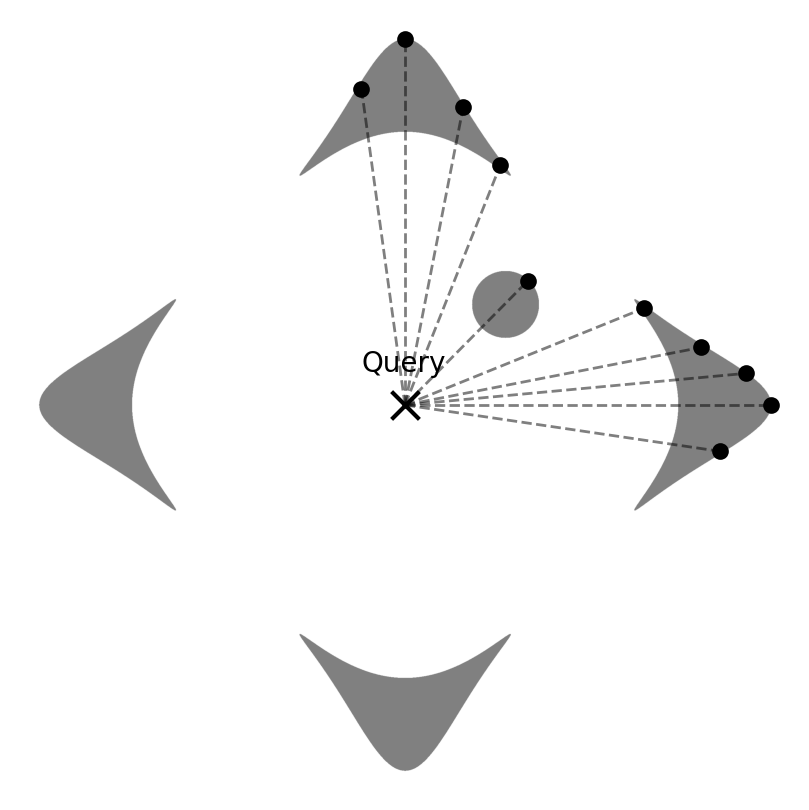

In [20]:
default_cfs_with_opt = generator.sample(num_samples=10)

plotcfs(validity, default_cfs_with_opt, x_query, ranges) #plot sampled counterfactuals

We can also take a look at all the counterfactuals we identify. We can see that counterfactuals to the top and right are prioritized during the search. 

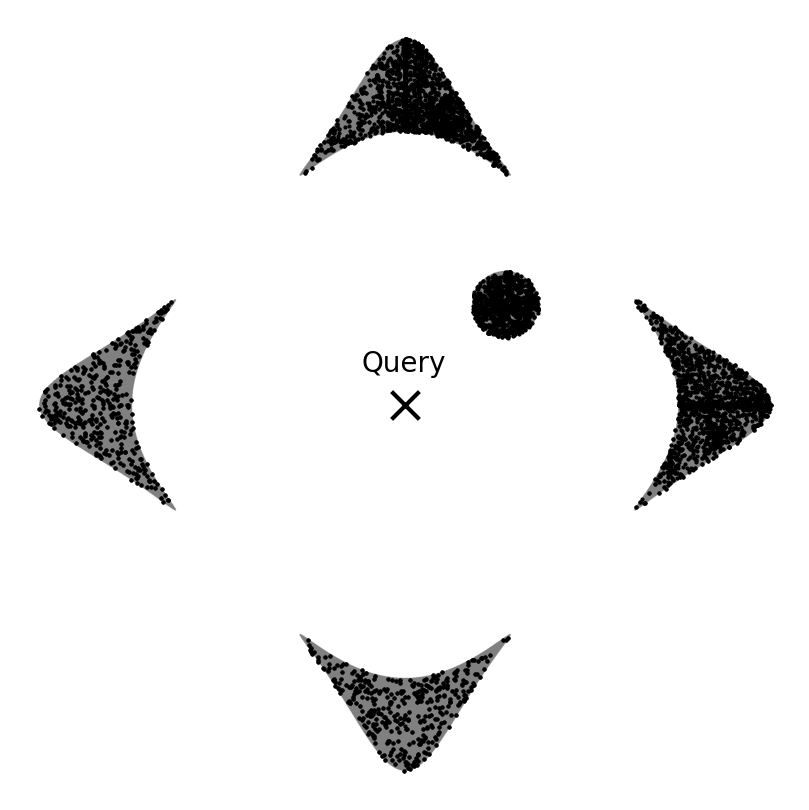

In [21]:
plotcfs(validity, generator._all_cf_x, x_query, ranges, links=False) #plot all counterfactuals

We can prioritize or deprioritize one of several objectives by specifying weights for the objectives. These weights are passed in as a numpy array which specify the weights of all `MinimizationTargets` in order. First, we prioritize both objectives over the other counterfactual quality objectives(proximity, sparsity, manifold proximity). Next, we prioritize objective 1 (maximize x1) over objective 2 (maximize x2).

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


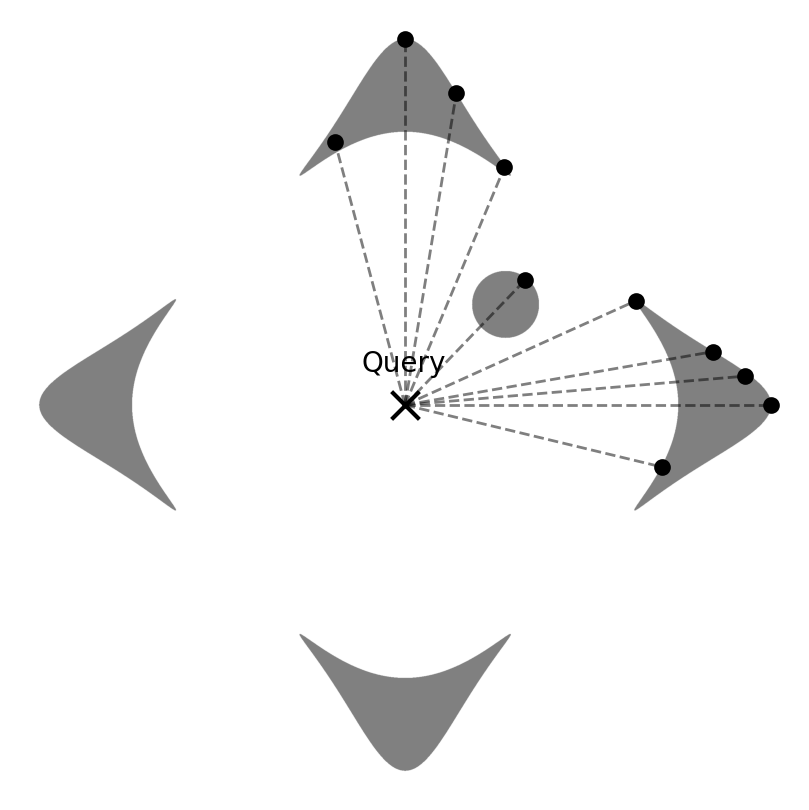

In [22]:
cfs_with_opt_2 = generator.sample(num_samples=10, bonus_objectives_weights = np.array([10,10]))

plotcfs(validity, cfs_with_opt_2, x_query, ranges)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


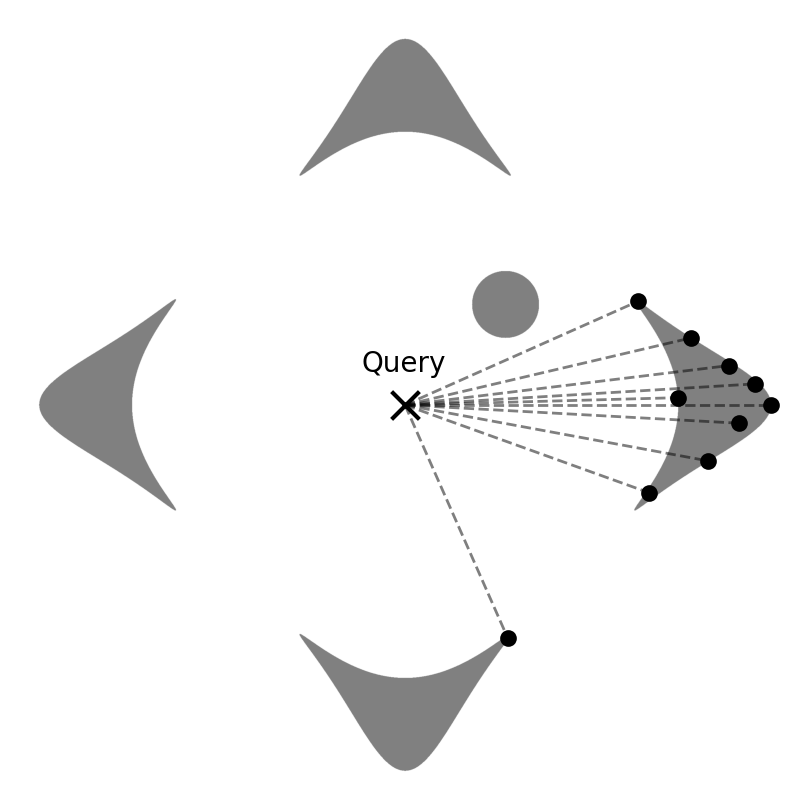

In [23]:
cfs_with_opt_3 = generator.sample(num_samples=10, bonus_objectives_weights = np.array([10,0.1]))

plotcfs(validity, cfs_with_opt_3, x_query, ranges)

This concludes the third MCD tutorial notebook! The final notebook will cover MCD's advanced customization options. 